c:\Users\mihre\Documents\KIAM\week 9\portfolio-optimization\venv311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\mihre\Documents\KIAM\week 9\portfolio-optimization\venv311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


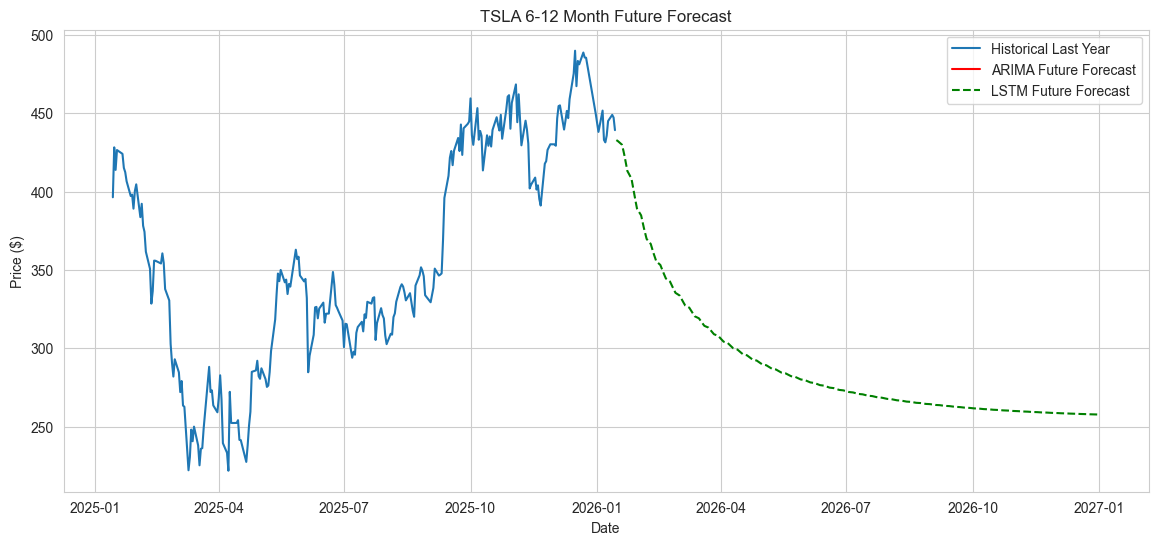

ARIMA Trend Analysis:
  Trend: stable
  Delta: nan
  Mean Price: nan, Std Dev: nan


LSTM Trend Analysis:
  Trend: downward
  Delta: -175.14
  Mean Price: 288.39, Std Dev: 40.25


Opportunities:
- Potential capital appreciation if upward trend continues.
- Use confidence intervals to plan entry points (e.g., ARIMA predicts expected range).

Risks:
- High volatility (check rolling std) may lead to drawdowns.
- Forecast uncertainty grows over time, especially for LSTM iterative predictions.


In [6]:
# ================================
# Task 3: Forecast Future Market Trends
# ================================

# -------------------------
# 1. Imports
# -------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# -------------------------
# 2. Load Forecasts from Task 2
# -------------------------
arima_forecast = pd.read_csv("../data/processed/tsla_arima_forecast.csv", index_col=0, parse_dates=True)
lstm_forecast = pd.read_csv("../data/processed/tsla_lstm_forecast.csv", index_col=0, parse_dates=True)

# Load historical data for context
tsla_prices = pd.read_csv("../data/processed/historical_prices.csv", index_col="Date", parse_dates=True)["TSLA"]

# -------------------------
# 3. Generate Future Forecasts (6-12 months)
# -------------------------
# For ARIMA, we can forecast next 12 months (approx 252 trading days)
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Fit ARIMA on full historical data
arima_model_full = auto_arima(tsla_prices, seasonal=False, trace=False, stepwise=True)
arima_model_full.fit(tsla_prices)
future_arima_forecast = pd.Series(arima_model_full.predict(n_periods=252),
                                  index=pd.date_range(start=tsla_prices.index[-1] + pd.Timedelta(days=1), periods=252, freq='B'))

# For LSTM, use last 60 days to iteratively predict next 252 days
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

scaler = MinMaxScaler(feature_range=(0,1))
tsla_scaled = scaler.fit_transform(tsla_prices.values.reshape(-1,1))

# Load previously trained LSTM model (or retrain here)
lstm_model = load_model("../models/lstm_tsla_model.h5") 
# For simplicity, we use last trained model in Task 2
# Simulate iterative predictions
seq_length = 60
lstm_pred_scaled = []
last_sequence = tsla_scaled[-seq_length:].reshape(1, seq_length, 1)

for i in range(252):  # forecast next 252 business days (~1 year)
    next_val = lstm_model.predict(last_sequence, verbose=0)
    lstm_pred_scaled.append(next_val[0,0])
    next_val_reshaped = next_val.reshape(1, 1, 1)
    last_sequence = np.concatenate([last_sequence[:,1:,:], next_val_reshaped], axis=1)

lstm_future_forecast = pd.Series(
    scaler.inverse_transform(np.array(lstm_pred_scaled).reshape(-1,1)).flatten(),
    index=pd.date_range(start=tsla_prices.index[-1] + pd.Timedelta(days=1), periods=252, freq='B')
)

# -------------------------
# 4. Visualize Forecasts
# -------------------------
plt.figure(figsize=(14,6))
plt.plot(tsla_prices[-252:], label='Historical Last Year')
plt.plot(future_arima_forecast, label='ARIMA Future Forecast', color='red')
plt.plot(lstm_future_forecast, label='LSTM Future Forecast', color='green', linestyle='--')
plt.title("TSLA 6-12 Month Future Forecast")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

# -------------------------
# 5. Trend Analysis
# -------------------------
def analyze_trend(series, name="Forecast"):
    delta = series.iloc[-1] - series.iloc[0]
    trend = "upward" if delta > 0 else "downward" if delta < 0 else "stable"
    print(f"{name} Trend Analysis:")
    print(f"  Trend: {trend}")
    print(f"  Delta: {delta:.2f}")
    print(f"  Mean Price: {series.mean():.2f}, Std Dev: {series.std():.2f}")
    print("\n")


analyze_trend(future_arima_forecast, "ARIMA")
analyze_trend(lstm_future_forecast, "LSTM")

# -------------------------
# 6. Opportunities and Risks
# -------------------------
print("Opportunities:")
print("- Potential capital appreciation if upward trend continues.")
print("- Use confidence intervals to plan entry points (e.g., ARIMA predicts expected range).")

print("\nRisks:")
print("- High volatility (check rolling std) may lead to drawdowns.")
print("- Forecast uncertainty grows over time, especially for LSTM iterative predictions.")
